In [2]:
import pandas as pd
import os
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
import joblib
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
%matplotlib inline

PATH_IN = '../generated/'

In [3]:
# Loading NLP data
tokens_fname = os.path.join(PATH_IN, 'tokens.parquet')
dependencies_fname = os.path.join(PATH_IN, 'dependencies.parquet')

tokens = pd.read_parquet(tokens_fname)
dependencies = pd.read_parquet(dependencies_fname)

### Preprocessing
Find movies that contain at least one character (from tokens check for atleast one `NER=="PERSON"`) and check that dependencies contain only the dependencies we are looking for as in *Learning Latent Personas of Film Characters* from David Bamman Brendan O’Connor Noah A. Smith.
![dep_needed](https://i.postimg.cc/sfbxBMV6/image-2023-11-15-113351627.png)

In [5]:
tokens[tokens["NER"] == "PERSON"].head(3) # using old annotations, NER can miss some characters, for example label them as ORGANIZATION
movies_with_atleast_one_person = tokens[tokens["NER"] == "PERSON"]["movie_id"].unique().tolist()
len(movies_with_atleast_one_person)

,movie_id,sentence_id,token_id,word,lemma,COB,COE,POS,NER
2,10000053,1,3,Jean,Jean,12,16,NNP,PERSON
3,10000053,1,4,La,La,17,19,NNP,PERSON
4,10000053,1,5,B,B,20,21,NNP,PERSON


38164

In [6]:
agent_verbs = ["agent", "nsubj"]
patient_verbs = ["dobj", "nsubjpass", "iobj"] # + prep_* (handled seperatly)
attributes_av = ["nsubj", "appos"]
attributes_pv = ["nsubj", "appos", "amod", "nn"]

dependencies_needed = dependencies[(dependencies["dependency_class"] == "collapsed-ccprocessed") & 
                                   ((dependencies["dependency_type"].isin(agent_verbs + patient_verbs + attributes_av + attributes_pv)) |  
                                    (dependencies["dependency_type"].str.startswith("prep_")))].copy()

dependencies_needed.head(3)

movies_with_atleast_one_dep = dependencies_needed["movie_id"].unique().tolist()

len(movies_with_atleast_one_dep)

,movie_id,sentence_id,dependency_class,dependency_type,governor_id,governor_word,dependent_id,dependent_word
41,10000053,1,collapsed-ccprocessed,nn,6,te,1,Fur
42,10000053,1,collapsed-ccprocessed,nn,6,te,2,trapper
43,10000053,1,collapsed-ccprocessed,nn,6,te,3,Jean


42304

In [7]:
set_movies_with_person = set(movies_with_atleast_one_person)
set_movies_with_dep = set(movies_with_atleast_one_dep)

common_movies = set_movies_with_person.intersection(set_movies_with_dep)

common_movies_list = list(common_movies)

len(common_movies_list)

38162

In [8]:
filtered_tokens = tokens[tokens["movie_id"].isin(common_movies_list)].copy()
filtered_dependencies = dependencies_needed[dependencies_needed["movie_id"].isin(common_movies_list)].copy()

filtered_tokens = filtered_tokens.drop(["COB", "COE"], axis=1)
filtered_dependencies = filtered_dependencies.drop(["dependency_class"], axis=1)

In [9]:
%%time
merge1 = pd.merge(filtered_tokens, filtered_dependencies,
                 left_on=['movie_id', 'sentence_id', 'token_id'],
                 right_on=['movie_id', 'sentence_id', 'governor_id'],
                 how='inner')

merge2 = pd.merge(filtered_tokens, filtered_dependencies,
                 left_on=['movie_id', 'sentence_id', 'token_id'],
                 right_on=['movie_id', 'sentence_id', 'dependent_id'],
                 how='inner')

merged_data = pd.concat([merge1, merge2]).drop_duplicates().reset_index(drop=True)
merged_data

CPU times: total: 59.3 s
Wall time: 59.4 s


,movie_id,sentence_id,token_id,word,lemma,POS,NER,dependency_type,governor_id,governor_word,dependent_id,dependent_word
0,10000053,1,6,te,te,NN,O,nn,6,te,1,Fur
1,10000053,1,6,te,te,NN,O,nn,6,te,2,trapper
2,10000053,1,6,te,te,NN,O,nn,6,te,3,Jean
3,10000053,1,6,te,te,NN,O,nn,6,te,4,La
4,10000053,1,6,te,te,NN,O,nn,6,te,5,B
...,...,...,...,...,...,...,...,...,...,...,...,...
10077137,9999280,6,5,reasons,reason,NNS,O,dobj,3,discovers,5,reasons
10077138,9999280,6,10,separation,separation,NN,O,prep_for,5,reasons,10,separation
10077139,9999280,6,13,Marcelo,Marcelo,NNP,PERSON,nn,15,reality,13,Marcelo
10077140,9999280,6,14,face,face,NN,O,nn,15,reality,14,face


In [11]:
merged_data[(merged_data["token_id"] != merged_data["governor_id"]) & (merged_data["token_id"] != merged_data["dependent_id"])] # should be empty ✅

,movie_id,sentence_id,token_id,word,lemma,POS,NER,dependency_type,governor_id,governor_word,dependent_id,dependent_word


In [14]:
# !pip install memory_profiler

%load_ext memory_profiler # install memory_profiler to use it, use %whos to see what's in memory
%memit
import gc

del common_movies
del set_movies_with_dep
del set_movies_with_person
del common_movies_list
del movies_with_atleast_one_dep
del movies_with_atleast_one_person

del dependencies_fname
del tokens_fname

del merge1
del merge2

del filtered_tokens
del filtered_dependencies

del dependencies_needed
del dependencies
del tokens

gc.collect()
%memit

peak memory: 16591.61 MiB, increment: 0.11 MiB


26

peak memory: 10968.22 MiB, increment: 0.00 MiB


### For each plot:
1. Extract the characters (NER=PERSON)
2. For each character extract (dependencies + coreference)
    - agent verbs
    - patient verbs
    - attributes

In [15]:
characters = pd.DataFrame(columns=['movie_id', 'character', 'AV', 'PV', 'Att']) # dataframe where we will store the character, its actions (agent and patient) and attributes
verb_pos_tags = ["VB", "VBD", "VBG", "VBN", "VBP", "VBZ"] # to indentify verbs from attributes

### Extractor using parallelization

In [ ]:
%%time
# there are more precise ways to do it, but as we are using not very accurate annotations data, we will spend more time enhancing the new annotations.

def process_group(chunk):
    temp_data = []
    for (movie_id, character), group in chunk.groupby(['movie_id', 'word']):
        AV, PV, Att = [], [], [] 

        for _, row in group.iterrows():
            if row['governor_word'] == character:
                dependency_word = row['dependent_word']
                dependency_idx = row['dependent_id']
            elif row['dependent_word'] == character:
                dependency_word = row['governor_word']
                dependency_idx = row['governor_id']
            else:
                print("Error")

            pos_row = merged_data[(merged_data['movie_id'] == movie_id) & 
                                  (merged_data['sentence_id'] == row['sentence_id']) & 
                                  (merged_data['token_id'] == dependency_idx)]

            if not pos_row.empty and pos_row.iloc[0]['POS'] in verb_pos_tags:
                if row['dependency_type'] in agent_verbs or row['dependency_type'].startswith("prep_"):
                    AV.append(pos_row.iloc[0]['lemma'])
                elif row['dependency_type'] in patient_verbs:
                    PV.append(pos_row.iloc[0]['lemma'])
            else:
                Att.append(pos_row.iloc[0]['lemma'])

        temp_data.append({
            'movie_id': movie_id,
            'character': character,
            'AV': AV,
            'PV': PV,
            'Att': Att
        })
    return temp_data

character_data = merged_data[merged_data["NER"] == "PERSON"]

num_partitions = joblib.cpu_count() 
chunk_size = int(character_data.shape[0] / num_partitions)
chunks = [character_data.iloc[i:i + chunk_size] for i in range(0, character_data.shape[0], chunk_size)]

results = Parallel(n_jobs=num_partitions)(delayed(process_group)(chunk) for chunk in tqdm(chunks))

flattened_results = [item for sublist in results for item in sublist]
characters = pd.concat([pd.DataFrame(flattened_results)], ignore_index=True)

In [ ]:
characters.to_parquet(os.path.join(PATH_IN, "characters_old_annotations.parquet"))

In [ ]:
characters # PV looks empty but it's not

### Generate bag of words
A bag is a tupple of $(r,w)$, where $r$ is of {agent verb, patient verb, attribute} and $w$ is the lemma of the word.

In [ ]:
def generate_bags_of_words(characters_df: pd.DataFrame):
    bags_of_words = []

    for _, row in tqdm(characters_df.iterrows()):
        movie_id = row['movie_id']
        character_name = row['character']

        av = row['AV'] if isinstance(row['AV'], list) else []
        pv = row['PV'] if isinstance(row['PV'], list) else []
        att = row['Att'] if isinstance(row['Att'], list) else []

        for verb in av:
            bags_of_words.append((movie_id, character_name, 'agent_verb', verb))

        for verb in pv:
            bags_of_words.append((movie_id, character_name, 'patient_verb', verb))

        for attribute in att:
            bags_of_words.append((movie_id, character_name, 'attribute', attribute))

    return bags_of_words

bags_of_words = generate_bags_of_words(characters)

In [ ]:
bags_df = pd.DataFrame(bags_of_words, columns=['movie_id', 'character_name', 'type', 'word'])
bags_df.to_parquet(os.path.join(PATH_IN, "bags_old_annotations.parquet"))

### From tupples to topics using LDA

In [21]:
# loading bags of words
bags_fname = os.path.join(PATH_IN,'bags_old_annotations.parquet')
bags_df = pd.read_parquet(bags_fname)
bags_of_words=bags_df.values

bags_df.head(3)

,movie_id,character_name,type,word
0,10193,Braithwaite,attribute,Intelligence
1,10193,Kelly,attribute,Jim
2,10193,Lee,attribute,attack


In [22]:
# currently global character version (doesn't make the distinction of the same character in different movies)
character_docs = defaultdict(list)
for _, character, _, word in bags_of_words:
    character_docs[character].append(word)
    
for character in character_docs:
    character_docs[character] = " ".join(character_docs[character])
    
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(character_docs.values())

n_topics = 50
lda = LatentDirichletAllocation(n_components=n_topics, verbose=2, max_iter=10, random_state = 0)
lda.fit(X)

In [ ]:
joblib.dump(lda, os.path.join(PATH_IN, "lda_model_old_annotations.pkl"))

In [14]:
lda = joblib.load(os.path.join(PATH_IN,'lda_model_old_annotations.pkl'))

/home/jessica/anaconda3/envs/ada/lib/python3.9/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LatentDirichletAllocation from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [25]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = f"Topic {topic_idx}: "
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)

n_topic_words = 10
print_top_words(lda, vectorizer.get_feature_names_out(), n_topic_words)

Topic #0: find kill tell take meet confront leave begin have force
Topic #1: von frank baron lt victor ray guy bobby head jake
Topic #2: peter james woo marie betty prasad he alfred christ fudd
Topic #3: dr scientist lead member doctor le psychiatrist explain kill have
Topic #4: chief robert kim ho cao mayor nick hai dan portray
Topic #5: thomas kill meet son raja go get try francis davis
Topic #6: officer ms lieutenant johnny anne jimmy set secretary lin movie
Topic #7: singh sir tom al major boy hyun involve company red
Topic #8: john charlie george detective president joseph reporter danny attorney play
Topic #9: don ali la anna evil jekyll lewis shah hill anand
Topic #10: miss ben eddie follow alice ed deputy neighbor long join
Topic #11: marry daughter fall have meet take wife tell be love
Topic #12: tell find go have leave take meet see be give
Topic #13: khan joe max commander superior die reverend jerry meet use
Topic #14: lord general mary eun bruce tell elmer san jin take
Top

In [32]:
character_topic = lda.transform(X)
character_names = list(character_docs.keys())

character_classification=[]

for i, topic_dist in enumerate(character_topic):
    topic_most_prob = topic_dist.argmax()
    character_classification.append((character_names[i], topic_most_prob, topic_dist))

character_classification_df=pd.DataFrame(character_classification,columns=['character_name', 'topic', 'topic_dist'])
character_classification_df.head(3)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   26.7s finished


,character_name,topic,topic_dist
0,Braithwaite,8,"[0.0011764705882365894, 0.0011764705882365894,..."
1,Kelly,23,"[1.7021276595851307e-05, 1.7021276595851307e-0..."
2,Lee,28,"[0.008421474304820637, 9.029345372522596e-06, ..."


In [23]:
character_classification_df.to_parquet(os.path.join(PATH_IN, "character_classification_old_annotations.parquet"))

,character_name,topic
0,Braithwaite,8
1,Kelly,23
2,Lee,28
3,Lin,48
4,Ling,15
5,Roper,23
6,Saxon,8
7,Williams,28
8,Annie,12
9,Getley,10


<Figure size 1600x600 with 0 Axes>

<BarContainer object of 50 artists>

Text(0.5, 0, 'Topic')

Text(0, 0.5, 'Probability')

Text(0.5, 1.0, 'Topic Distribution for Batman')

([<matplotlib.axis.XTick at 0x1852e64ac20>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20'),
  Text(21, 0, '21'),
  Text(22, 0, '22'),
  Text(23, 0, '23'),
  Text(24, 0, '24'),
  Text(25, 0, '25'),
  Text(26, 0, '26'),
  Text(27, 0, '27'),
  Text(28, 0, '28'),
  Text(29, 0, '29'),
  Text(30, 0, '30'),
  Text(31, 0, '31'),
  Text(32, 0, '32'),
  Text(33, 0, '33'),
  Text(34, 0, '34'),
  Text(35, 0, '35'),
  Text(36, 0, '36'),
  Text(37, 0, '37'),
  Text(38, 0, '38'),
  Text(39, 0, '39'),
  Text(40, 0, '40'),
  Text(41, 0, '41'),
  Text(42, 0, '42'),
  Text(43, 0, '43'),
  Text(44, 0, '44'),
  Text(45, 0, '45'),
  Text(46,

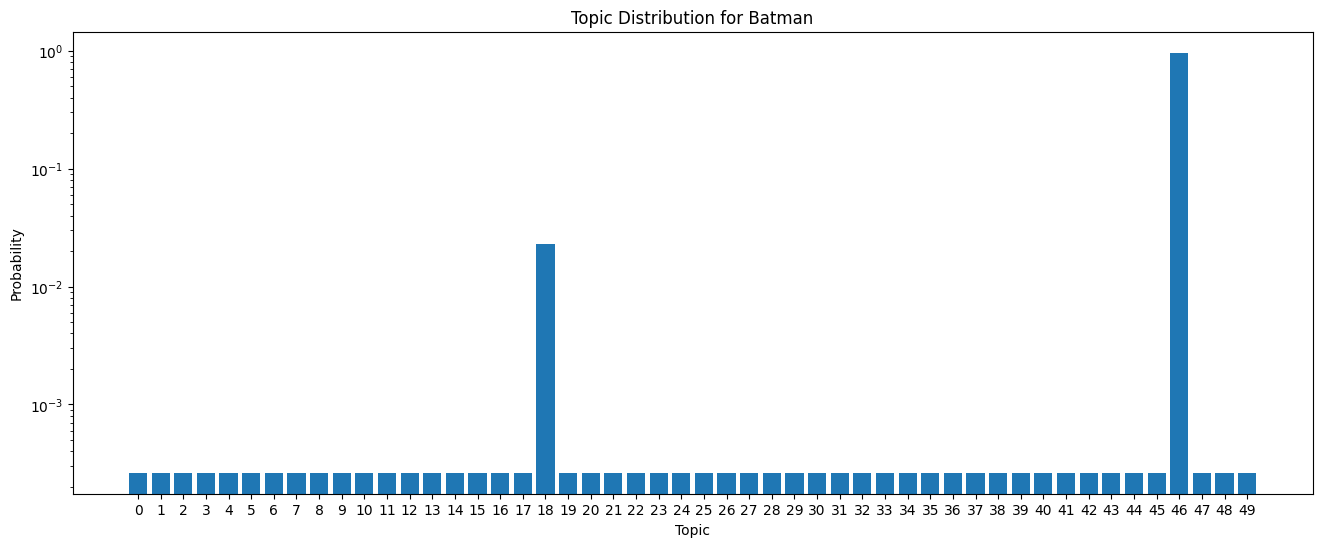

In [39]:
character='Batman'

character_topics = character_classification_df[character_classification_df['character_name'] == character]['topic_dist'].iloc[0]

topics = range(len(character_topics))

# Creating the plot
plt.figure(figsize=(16, 6))
plt.bar(topics, batman_topics)
plt.xlabel('Topic')
plt.ylabel('Probability (log scale)')
plt.title(f'Topic Distribution for {character}')
plt.yscale('log')  
plt.xticks(topics)
plt.show()

<Figure size 1600x600 with 0 Axes>

<BarContainer object of 50 artists>

Text(0.5, 0, 'Topic')

Text(0, 0.5, 'Number of Characters')

Text(0.5, 1.0, 'Distribution of Characters Across Topics')

([<matplotlib.axis.XTick at 0x1856e4d96f0>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20'),
  Text(21, 0, '21'),
  Text(22, 0, '22'),
  Text(23, 0, '23'),
  Text(24, 0, '24'),
  Text(25, 0, '25'),
  Text(26, 0, '26'),
  Text(27, 0, '27'),
  Text(28, 0, '28'),
  Text(29, 0, '29'),
  Text(30, 0, '30'),
  Text(31, 0, '31'),
  Text(32, 0, '32'),
  Text(33, 0, '33'),
  Text(34, 0, '34'),
  Text(35, 0, '35'),
  Text(36, 0, '36'),
  Text(37, 0, '37'),
  Text(38, 0, '38'),
  Text(39, 0, '39'),
  Text(40, 0, '40'),
  Text(41, 0, '41'),
  Text(42, 0, '42'),
  Text(43, 0, '43'),
  Text(44, 0, '44'),
  Text(45, 0, '45'),
  Text(46,

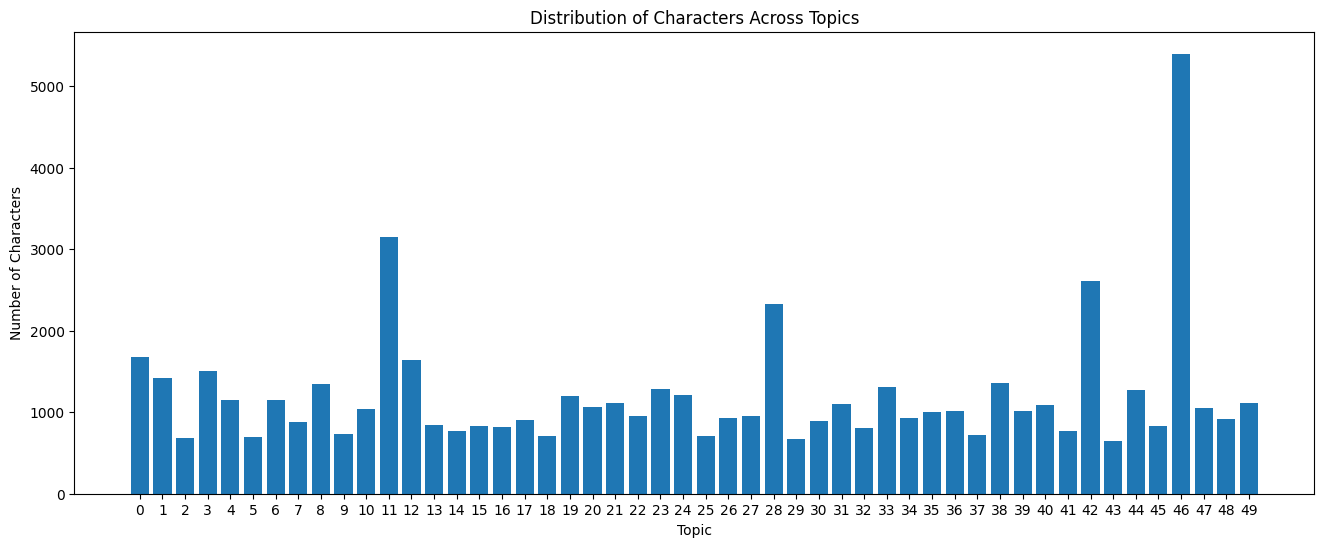

In [42]:
topic_counts = character_classification_df['topic'].value_counts()

topic_counts = topic_counts.sort_index()

plt.figure(figsize=(16, 6))
plt.bar(topic_counts.index, topic_counts.values)

plt.xlabel('Topic')
plt.ylabel('Number of Characters')
plt.title('Distribution of Characters Across Topics')
plt.xticks(topic_counts.index)
plt.show()